
# LSTM in Non Linear Sequence

In [73]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

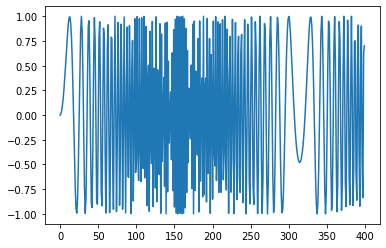

In [74]:
series = np.sin((0.1*np.arange(400))**2)

plt.plot(series)
plt.show()

In [75]:
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # make it N x T
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10, 1) Y.shape (390, 1)


In [76]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [77]:
class RNN_LSTM(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN_LSTM, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers


    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc =nn.Linear(self.M, self.K)
  
  def forward(self, X):
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, _ = self.rnn(X, (h0, c0))


    out = self.fc(out[:, -1, :])
    return out

In [78]:
model = RNN_LSTM(n_inputs=1, n_hidden=10, n_rnnlayers=1, n_outputs=1)
model.to(device)

RNN_LSTM(
  (rnn): LSTM(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [79]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.05)

X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [80]:
# Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):

  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
      
    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()
      
    if (it + 1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
  
  return train_losses, test_losses

In [81]:

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.5029, Test Loss: 0.5798
Epoch 10/200, Train Loss: 0.4802, Test Loss: 0.6290
Epoch 15/200, Train Loss: 0.4389, Test Loss: 0.5358
Epoch 20/200, Train Loss: 0.4025, Test Loss: 0.5286
Epoch 25/200, Train Loss: 0.2808, Test Loss: 0.3607
Epoch 30/200, Train Loss: 0.1280, Test Loss: 0.2591
Epoch 35/200, Train Loss: 0.0666, Test Loss: 0.1572
Epoch 40/200, Train Loss: 0.0326, Test Loss: 0.1009
Epoch 45/200, Train Loss: 0.0272, Test Loss: 0.0864
Epoch 50/200, Train Loss: 0.0185, Test Loss: 0.0890
Epoch 55/200, Train Loss: 0.0138, Test Loss: 0.0676
Epoch 60/200, Train Loss: 0.0104, Test Loss: 0.0690
Epoch 65/200, Train Loss: 0.0070, Test Loss: 0.0640
Epoch 70/200, Train Loss: 0.0060, Test Loss: 0.0633
Epoch 75/200, Train Loss: 0.0050, Test Loss: 0.0624
Epoch 80/200, Train Loss: 0.0042, Test Loss: 0.0588
Epoch 85/200, Train Loss: 0.0036, Test Loss: 0.0588
Epoch 90/200, Train Loss: 0.0032, Test Loss: 0.0554
Epoch 95/200, Train Loss: 0.0028, Test Loss: 0.0555
Epoch 100/200

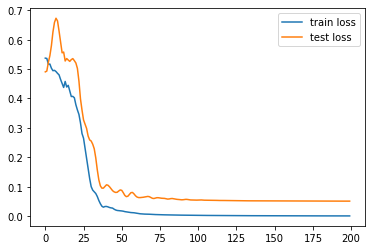

In [82]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [83]:

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)
  # [0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p[0,0].item())
  
  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

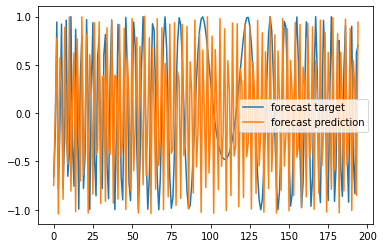

In [84]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()